In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib

matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rcParams['axes.labelweight'] = 'bold'

# Import functions factorized out for ease of viewing
from recommender_functions import *

# This notebook builds a model to make book recommendations to users for books outside their comfort genre

The final product can be found here:
http://shelfexplorer.site/

# Grab ratings info by user and book

In [2]:
# Get the ratings by user; this starts at user index 1 
r = pd.read_csv('goodbooks-10k/user_ratings.csv')
df_u_ratings = pd.DataFrame(r)
df_u_ratings['user_counts'] = df_u_ratings.groupby(['user_id'])['book_id'].transform('count')
df_u_ratings['book_counts'] = df_u_ratings.groupby(['book_id'])['user_id'].transform('count')

# Apply user + book cuts and add a user index for matrix building later
cut_u, cut_b = 175, 1
df_u_ratings = df_u_ratings.query('user_counts > %d & book_counts > %d'%(cut_u,cut_b))
df_u_ratings['user_idx'] = pd.Categorical(df_u_ratings['user_id']).codes 
df_u_ratings['book_idx'] = pd.Categorical(df_u_ratings['book_id']).codes 

# Set number of books and users variables for later use
N_BOOKS = len(df_u_ratings.book_id.unique()) 
N_USERS = len(df_u_ratings.user_id.unique())

In [3]:
print('Users and books in our matrix: (%d,%d)'%(N_USERS,N_BOOKS))

Users and books in our matrix: (537,7337)


In [4]:
# Get the ratings by book; this starts at book index 1 
r = pd.read_csv('goodbooks-10k/book_ratings.csv')
df_b_ratings = pd.DataFrame(r)

# Get the most popular genre tags
r = pd.read_csv('goodbooks-10k/genre_tags.csv')
df_tags = pd.DataFrame(r)
df_tags['tag_index'] = pd.Categorical(df_tags['tag_id']).codes 

## Build recommendation matrix

In [5]:
# First build ratings and genre matrices and fill in ratings zeros with averages
ratings_mat, genre_mat = build_rank_matrix(df_u_ratings,df_b_ratings)
ratings_mat, user_ave_mat = impute_matrix(ratings_mat)

In [6]:
print('Ratings matrix is shape (%d,%d)'%(ratings_mat.shape[0],ratings_mat.shape[1]))

Ratings matrix is shape (537,7337)


In [7]:
# Next, split data between train and test (roughly 80:20 split)
train_set, test_set = train_test_split(ratings_mat,split=1400)
print('Split Train %:' ,float(len(np.nonzero(train_set)[0]))/(len(np.nonzero(train_set)[0])+len(np.nonzero(test_set)[0]))*100)
print('Split Test  %:' ,float(len(np.nonzero(test_set)[0]))/(len(np.nonzero(train_set)[0])+len(np.nonzero(test_set)[0]))*100)

Split Train %: 80.91863159329426
Split Test  %: 19.08136840670574


In [8]:
# Calculate similarity between different users in the set
user_similarity = fast_similarity(train_set,kind='user')

In [9]:
# Get user predictions 
user_prediction_topk = predict_topk(train_set, user_similarity, kind='user')

## Validate the model

In [10]:
# We now have recommendations! Before we validate, we need to mask out user's favorite genre 
top_genres_per_user = get_user_genre_pref(df_tags,genre_mat)

# Build a matrix to blind user's top genres from test set recommendations
blind_mat = blind_users_fav_genre(genre_mat,top_genres_per_user)
blind_test_set = test_set.copy() * blind_mat

In [11]:
# Gather information on truth and predicted values
blind_y_true = blind_test_set[blind_test_set > 0]
blind_y_pred = user_prediction_topk[blind_test_set > 0]

# Binarize true values and predictions using user's average rating as a threshold
user_ave_thresholds = user_ave_mat[blind_test_set > 0]

blind_y_true_binarized = binarize(blind_y_true.copy(), user_ave_thresholds)
blind_y_pred_binarized = binarize(blind_y_pred.copy(), user_ave_thresholds) 

In [12]:
# Calculate the ave precision per user 

# First, identify user ids per ranking
all_user_ids = np.array([np.arange(N_USERS)]).T
user_id_matrix = np.tile(all_user_ids,(1,N_BOOKS)) 

# Now we have a matrix N_USERS x N_BOOKS wide with user ids across corresponding rows
user_ids = user_id_matrix[blind_test_set > 0]

# Now calculate the average precision per user over a range of #recommended books 
precision_v = [precision_at_k(blind_y_true_binarized, blind_y_pred, blind_y_pred_binarized, 
                        user_ids, i, tol=user_ave_thresholds) for i in range(1,30)]

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0, 30)

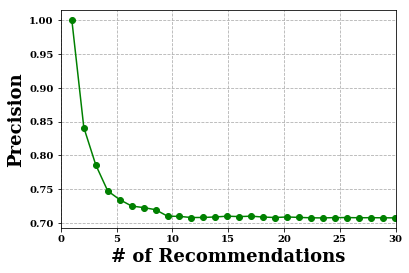

In [13]:
plt.figure(figsize=(6,4))
x=np.linspace(1,31,29)
plt.plot(x,precision_v,'-o',color='green')
plt.xlabel('# of Recommendations',fontsize=18,weight='bold')
plt.ylabel('Precision',fontsize=18,weight='bold')
plt.grid(True,ls='--')
plt.savefig('Plots/ave_user_precision.png',bbox_inches='tight')
plt.xlim(0,30)